In [14]:
%load_ext autoreload
%autoreload 2

import gym
from matplotlib import pyplot as plt
from collections import deque
import numpy as np

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
class Actor(nn.Module):
    """Some Information about ActorCritic"""
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        return self.model(x)
    
class Critic(nn.Module):
    """Some Information about ActorCritic"""
    def __init__(self, state_size):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

class Memory:
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.dones = []
        self.rewards = []
    
    def add(self, log_prob, value, done, reward):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.dones.append(done)
        self.rewards.append(reward)
    
    def clear(self):
        self.log_probs = []
        self.values = []
        self.dones = []
        self.rewards = []
    
    def __len__(self):
        return len(self.log_probs)

In [17]:
def update(mem, next_state):
    q_values = []
    
    # Do not add this one as it's for the next state
    running_reward = critic(torch.tensor(next_state).float().to(device))
    
    for reward, done in zip(reversed(mem.rewards), reversed(mem.dones)):
        running_reward = (reward + gamma * running_reward) * (1-done)
        
        q_values.append(running_reward)
    
    q_values = torch.stack(q_values).to(device)
    values = torch.stack(mem.values).to(device)
    log_probs = torch.stack(mem.log_probs).to(device)
    
    advantage = q_values - values
    
    critic_loss = torch.pow(advantage, 2).mean()
    actor_loss = (-log_probs * advantage).sum()
    
    critic_optim.zero_grad()
    critic_loss.backward(retain_graph=True)
    critic_optim.step()
    
    actor_optim.zero_grad()
    actor_loss.backward(retain_graph=True)
    actor_optim.step()

In [18]:
# env = gym.make("CartPole-v1")
env = gym.make("LunarLander-v2")


state_space = env.observation_space.shape[0]
action_space = env.action_space.n

/home/ubuntu/anaconda3/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [26]:
win_condition = 200

num_episodes = 2000
bootstrap_len = 15

gamma = 0.99

In [27]:
mem = Memory()

actor = Actor(state_space, action_space).to(device)
critic = Critic(state_space).to(device)

actor_optim = optim.Adam(actor.parameters(), lr=0.02)
critic_optim = optim.Adam(critic.parameters(), lr=0.02)

In [ ]:
running_scores = deque(maxlen=100)
score_log = []
average_score_log = []


t = 0
for i in range(num_episodes):
    state = env.reset()
    steps = 0
    score = 0
    
    while True:
        steps += 1
            
        value = critic(torch.tensor(state).float().to(device))
        logits = F.softmax(actor(torch.tensor(state).float().to(device)))
        
        probabilities = Categorical(logits)
        action = probabilities.sample()
        log_probs = probabilities.log_prob(action)

        next_state, reward, done, _ = env.step(action.cpu().numpy())
        score += reward

        mem.add(log_probs, value, done, reward)

        if (done or steps % bootstrap_len == 0):
            update(mem, next_state)
            mem.clear()
        
        if done:
            break
        
        state = next_state

    score_log.append(score)
    running_scores.append(score)
    average_score_log.append(np.mean(running_scores))
    
    print("\rEpisode: {:.4f}\taverage: {:.4f}\tReward: {:.4f}".format(i, np.mean(running_scores), score), end="")
    
    if i % 100 == 0:
        print("\rEpisode: {:.4f}\taverage: {:.4f}\tReward: {:.4f}".format(i, np.mean(running_scores), score))
    
    if np.mean(running_scores) > win_condition:
        print("\rEnvironment Solved!")
        break

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Episode: 0.0000	average: -244.6905	Reward: -244.6905
Episode: 100.0000	average: -757.3661	Reward: -436.9430
Episode: 200.0000	average: -772.8600	Reward: -729.29455
Episode: 300.0000	average: -909.5003	Reward: -453.19391
Episode: 400.0000	average: -880.4513	Reward: -1145.2869
Episode: 500.0000	average: -912.5260	Reward: -2345.0861
Episode: 600.0000	average: -883.1110	Reward: -700.44573
Episode: 661.0000	average: -904.0672	Reward: -1705.6702

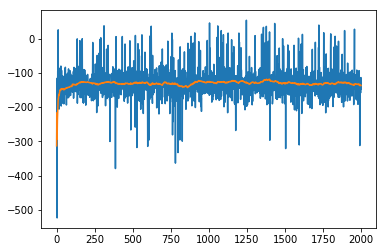

In [25]:
plt.plot(score_log)
plt.plot(average_score_log)